# 1. 분석 주제

### 1) 분석 배경

* 금번 2020 미국 대선에서 모든 언론은 바이든의 압승을 예상했음
* Shy Trump에 대한 우려도 존재했으나, 2016년 대선 예측 실패를 교훈 삼아 보정했다는 의견이 다수
* But, 그럼에도 불구하고 바이든 당선인의 승리는 압승이 아닌 신승에 가까웠음
* 개인 프로젝트에서 어떤 부분에서 언론사 예측에서 문제가 있었는 지 파악하고자 함

### 2) 분석 방법

* 고민 중 (일단, 마음가는대로)
* 향후 인구 구성 및 경제 수준 관련 자료를 가지고 추가 분석 필요
* 예측 데이터는 fivethirtyeight 데이터 참고 (https://data.fivethirtyeight.com/)

# 2. 데이터 분석

### 1) Import Library

In [1]:
import csv
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import re
import os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def mean_absolute_percent_error(y_true, y_pred) :
    return np.mean(np.abs((y_true - y_pred)/y_true))

def mean_percent_error(y_true, y_pred) :
    return np.mean((y_true-y_pred)/y_true)

### 2) Load forecast data (from FiveThirtyEight)

In [3]:
base_dir = os.getcwd()
election_dir = os.path.join(base_dir,'election-forecasts-2020')
for i in os.listdir(election_dir) :
    print(i)

economic_index.csv
electoral_college_vs_popvote.csv
house_district_toplines_2020.csv
house_fundamentals.csv
house_national_toplines_2020.csv
house_seat_distribution.csv
house_steps.csv
joint_probabilities.csv
presidential_ev_probabilities_2020.csv
presidential_forecast_steps.csv
presidential_national_toplines_2020.csv
presidential_polls_2020.csv
presidential_poll_averages_2020.csv
presidential_scenario_analysis_2020.csv
presidential_state_toplines_2020.csv
README.md
senate_fundamentals.csv
senate_national_toplines_2020.csv
senate_seat_distribution.csv
senate_state_toplines_2020.csv
senate_steps.csv


In [4]:
df_fcst = pd.read_csv(os.path.join(election_dir, 'presidential_state_toplines_2020.csv'))
df_fcst.head()

,cycle,branch,model,modeldate,candidate_inc,candidate_chal,candidate_3rd,state,tipping,vpi,...,margin_lo,win_EC_if_win_state_inc,win_EC_if_win_state_chal,win_state_if_win_EC_inc,win_state_if_win_EC_chal,state_turnout,state_turnout_hi,state_turnout_lo,timestamp,simulations
0,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,Wyoming,0.000000,0.000000,...,24.50582,0.104044,0.984615,0.999759,0.001795,274642.0,319577.0,231459.0,00:00:48 3 Nov 2020,40000
1,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,Wisconsin,0.053137,2.543351,...,-14.89797,0.771821,0.931934,0.419153,0.986261,3325739.0,3748885.0,2908762.0,00:00:48 3 Nov 2020,40000
2,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,West Virginia,0.000063,0.015240,...,18.01854,0.104550,0.986063,0.999038,0.007935,749616.0,868161.0,635685.0,00:00:48 3 Nov 2020,40000
3,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,Washington,0.002288,0.082997,...,-34.12025,0.263314,0.892971,0.021415,0.993074,4429891.0,5013615.0,3857496.0,00:00:48 3 Nov 2020,40000
4,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,Virginia,0.009850,0.341279,...,-18.56248,0.767263,0.898129,0.072185,0.997476,4599938.0,5189515.0,4020238.0,00:00:48 3 Nov 2020,40000


In [5]:
# table pivotting
pi_fcst = df_fcst.groupby(['modeldate', 'state'])['voteshare_inc', 'voteshare_chal'].mean().unstack('modeldate')

# creat column list
col_name = []
for i in pi_fcst.columns :
    if 'inc' in i[0] :
        col_name.append('inc_'+ i[1])
    else :
        col_name.append('chal_'+ i[1])

# column renamming
pi_fcst.columns = col_name
inc_col = [i for i in col_name if 'inc' in i]
chal_col = [i for i in col_name if 'chal' in i]

pi_fcst.reset_index(inplace=True)

### 3) Election results crawling

In [6]:
html = urlopen('https://en.wikipedia.org/wiki/2020_United_States_presidential_election')
bs = BeautifulSoup(html, 'html.parser')

table = bs.findAll('table', {'class':'wikitable'})[13]
rows = table.findAll('tr')

In [7]:
# Load election results
df = {}

#try :
colRow = []
for n, row in enumerate(rows) :  
    csvRow = []
    for n2, cell in enumerate(row.findAll(['td', 'th'])) : # td는 table data, th는 table header
        if n2 in [0,1,2,4,5] :
            csvRow.append(cell.get_text())
        else :
            pass
        #print(csvRow)
    #writer.writerow(csvRow)
    if n < 2 :
        pass
    else :
        df[str(n)] = csvRow
        
res_df = pd.DataFrame(df).T
real_res = res_df.reset_index().drop('index',1)\
.rename(columns={0:'State', 1:'Biden_Votes', 2:'Biden_%', 3:'Trump_Votes', 4:'Trump_%'}).drop([56, 57], 0)

In [8]:
real_res.head()

,State,Biden_Votes,Biden_%,Trump_Votes,Trump_%
0,Ala.,"849,624",36.57%,"1,441,170",62.03%
1,Alaska,"153,778",42.77%,"189,951",52.83%
2,Ariz.,"1,672,143",49.36%,"1,661,686",49.06%
3,Ark.,"423,932",34.78%,"760,647",62.40%
4,Calif.,"11,110,250",63.48%,"6,006,429",34.32%


### 4) Data Cleansing

In [9]:
# Load state's full name

table = bs.findAll('table', {'class':'wikitable'})[10]
rows = table.findAll('tr')

df = {}

#try :
csvRow = []
for n, row in enumerate(rows) :  
    for n2, cell in enumerate(row.findAll(['td', 'th'])) : # td는 table data, th는 table header
        if n2 in [0] :
            csvRow.append(cell.get_text().strip('\n'))
            
csvFin = csvRow[2:-1]

In [10]:
# change state name
real_res['State'] = csvFin

In [11]:
real_res.head()

,State,Biden_Votes,Biden_%,Trump_Votes,Trump_%
0,Alabama,"849,624",36.57%,"1,441,170",62.03%
1,Alaska,"153,778",42.77%,"189,951",52.83%
2,Arizona,"1,672,143",49.36%,"1,661,686",49.06%
3,Arkansas,"423,932",34.78%,"760,647",62.40%
4,California,"11,110,250",63.48%,"6,006,429",34.32%


In [12]:
real_res['Biden_%'] = real_res['Biden_%'].apply(lambda x : float(x.strip('%')))
real_res['Trump_%'] = real_res['Trump_%'].apply(lambda x : float(x.strip('%')))

real_res.rename(columns = {'State':'state'}, inplace=True)

In [13]:
# check merge error
print('null check:',pd.merge(real_res, pi_fcst, on = 'state').isnull().sum().sum())
print('shape check:', pd.merge(real_res, pi_fcst, on = 'state').shape)

all_df = pd.merge(real_res, pi_fcst, on = 'state')

null check: 0
shape check: (56, 317)


In [14]:
# Calculate the mape

b_mape = []
b_mpe = []
for i in chal_col :
    b_mape.append(mean_absolute_percent_error(all_df['Biden_%'], all_df[i]))
    b_mpe.append(mean_percent_error(all_df['Biden_%'], all_df[i]))

t_mape = []
t_mpe = []
for i in inc_col :
    t_mape.append(mean_absolute_percent_error(all_df['Trump_%'], all_df[i]))
    t_mpe.append(mean_percent_error(all_df['Trump_%'], all_df[i]))

# creat the index
dt_col = []
for i in chal_col :
    dt_col.append(i.strip('chal_'))

# creat the df
mape_df = pd.DataFrame({'date':dt_col,'b_mape': b_mape, 'b_mpe':b_mpe,'t_mape':t_mape, 't_mpe':t_mpe})
mape_df['date'] = pd.to_datetime(mape_df['date'])

mape_df.index = mape_df['date']
mape_df.drop('date',1,inplace=True)
mape_df.sort_index(inplace=True)

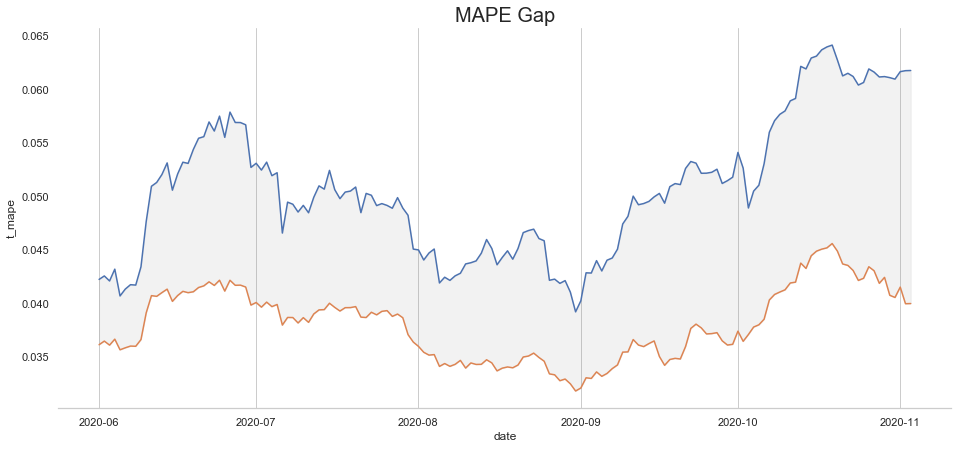

In [15]:
f, ax = plt.subplots(1,1, figsize=(16,7))
sns.lineplot(x=mape_df.index, y=mape_df['b_mape'], ax=ax)
sns.lineplot(x=mape_df.index, y=mape_df['t_mape'], ax=ax)
ax.fill_between(mape_df.index,mape_df['b_mape'], mape_df['t_mape'], color='grey', alpha='0.1')
ax.yaxis.grid(False)
ax.set_title('MAPE Gap', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.axis('off')

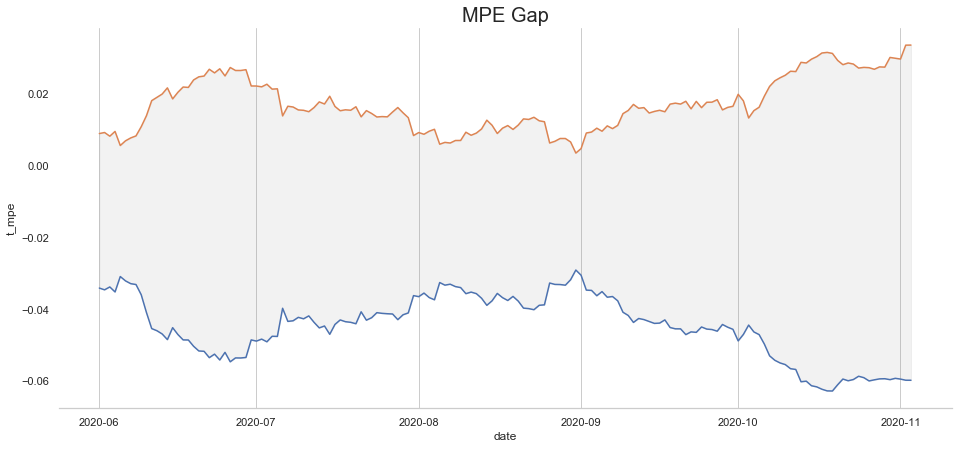

In [16]:
f, ax = plt.subplots(1,1, figsize=(16,7))
sns.lineplot(x=mape_df.index, y=mape_df['b_mpe'], ax=ax)
sns.lineplot(x=mape_df.index, y=mape_df['t_mpe'], ax=ax)
ax.fill_between(mape_df.index,mape_df['b_mpe'], mape_df['t_mpe'], color='grey', alpha='0.1')
ax.yaxis.grid(False)
#ax.yaxis.grid(color='light grey', linewidth=1)
ax.set_title('MPE Gap', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

* 일관되게 Biden 당선인의 mape는 높았고, trump 당선인의 mape는 낮았음
* 심지어 마지막 시점 11/3에는 바이든은 주 평균, 2% point 이상 과대 예측되고, 트럼프는 6% point 정도 과소 예측되었음
* shy trump가 이번에도 존재했다는 것을 확인 가능

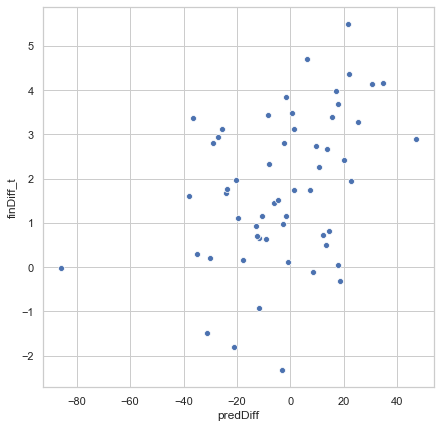

In [17]:
i_fin = 'inc_11/3/2020'
c_fin = 'chal_11/3/2020'

all_df['finDiff_b'] = all_df['Biden_%'] - all_df[c_fin]
all_df['finDiff_t'] = all_df['Trump_%'] - all_df[i_fin] 
all_df['predDiff'] = all_df[i_fin] - all_df[c_fin]
all_df['resDiff'] = all_df['Trump_%'] - all_df['Biden_%']

plt.figure(figsize=(7,7))
sns.scatterplot(all_df['predDiff'], all_df['finDiff_t'])
#sns.scatterplot(all_df['finDiff_b'], all_df['resDiff'])

In [18]:
all_df[['predDiff', 'finDiff_t']].corr()

,predDiff,finDiff_t
predDiff,1.000000,0.388475
finDiff_t,0.388475,1.000000


* 트럼프와 바이든 후보의 격차가 클수록 트럼프 실제와 예측간 결과도 컸다는 것을 볼 수 있음 
* 정리하자면, 예측시 트럼프와 바이든 후보 격차가 클수록 여론조사에서 잡아내지 못한 '샤이 트럼프' 규모도 컸던 거 같음
* 다만 차이가 컸지만 오차는 거의 0% point인 washington 특별구도 존재

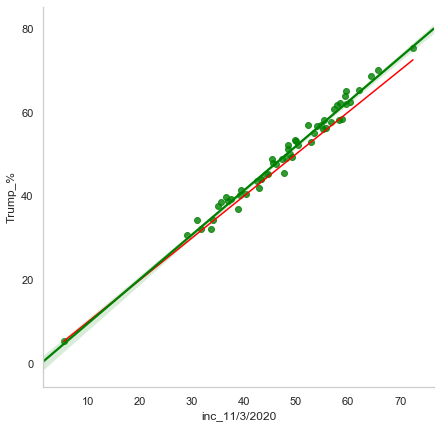

In [19]:
f, ax = plt.subplots(1,1, figsize=(7,7))
sns.lineplot( all_df[i_fin], all_df[i_fin],ax=ax, c='red')
sns.regplot(all_df[i_fin], all_df['Trump_%'], color='green')
#sns.scatterplot(all_df[i_fin],all_df['Trump_%'],  ax=ax)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)


* 위 그래프를 보면, 트럼프 예측이 높을 수록 실제 결과가 기울기 1인 빨간 직선 위로 더 높게 형성되어있음
* 실제로 두 변수의 회귀선은 기울기가 1보다 조금 높음을 볼 수 있음